## OTEC Modeling. Idealized Rankine Cycle

**States**
1. Exiting the Evaporator
2. Exiting the Turbine/Generator
3. Exiting the Condensor
4. Exiting the Pump/Compressor


**Assumptions**
* No superheating/cooling. Fluid leaving the evaporator is a saturated vapor. Fluid leaving the condensor is a saturated liquid. 
* Gross power output of the turbine is 125kW
* Temperature of cold ocean water is 5C
* Temperature of hot ocean water is 30C
* The working fluid can only be within 5C of either hot/cold fluid source
* Pump and Turbine are isentropic
* Condenser is a isobaric and isothermal process
* Evaporator is a isobaric process


**Next Steps**
* Model pressure drop across evaporator and condenser (Vera says 0.0015 bar)
* Model isentropic inefficiencies in turbine and pump

**Questions**
* Because the specific heat of water is different than most working fluids, we can't just compare the end temperatures right? 1 unit of temperature change in water represents a lot more energy than 1 unit of temperature change in the working fluid. How do we reconcile the energy based adiabatic analysis with the simplified temperature analysis? 

## Model Rankine Cycle

In [11]:
import CoolProp.CoolProp as CP
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import pandas as pd
from scipy.optimize import curve_fit



class State:
    # Simple object to hold different state variables.
    def __init__(self, t, p, h, s, q=None):
        self.t = t
        self.p = p
        self.h = h
        self.s = s
        self.q = q

def calc_state(p1, p2, sub='NH3'):
    # Assumes no superheating/cooling (q1 = 1, q3 = 0)

    # State 1: Exiting Evaporator
    q1 = 1
    h1 = CP.PropsSI('H', 'Q', q1, 'P', p1, sub)
    s1 = CP.PropsSI('S', 'Q', q1, 'P', p1, sub)
    t1 = CP.PropsSI('T', 'Q', q1, 'P', p1, sub)
    state1 = State(t1, p1, h1, s1, q1)

    # State 2: Exiting the turbine
    s2 = s1
    t2 = CP.PropsSI('T', 'S', s2, 'P', p2, sub)
    h2 = CP.PropsSI('H', 'S', s2, 'P', p2, sub)
    q2 = CP.PropsSI('Q', 'S', s2, 'P', p2, sub)
    state2 = State(t2, p2, h2, s2, q2)
    
    # State 3: Exiting Condensor
    q3 = 0
    t3 = t2
    p3 = p2
    h3 = CP.PropsSI('H', 'Q', q3, 'P', p3, sub)
    s3 = CP.PropsSI('S', 'Q', q3, 'P', p3, sub)
    state3 = State(t3, p3, h3, s3, q3)

    # State 4: Exiting Pump
    s4 = s3
    p4 = p1
    h4 = CP.PropsSI('H', 'S', s4, 'P', p4, sub)
    t4 = CP.PropsSI('T', 'H', h4, 'S', s4, sub)
    state4 = State(t4, p4, h4, s4)
    
    return (state1, state2, state3, state4)

def calc_temp(depth):
    # Calculates the ocean temperature for a given depth. Interpolates data from thermocline
    depths_ref = [0, 500, 1000, 1500, 3500, 6000]
    temps_ref = [24, 20, 7, 5, 4, 2]
    
    return np.interp(depth, depths_ref, temps_ref)

def calc_constraints(t_cold, plot = False):
    # Convert temperature in celsius to kelvin and add pinch temperature
    t_cold += 5 + 273
    
    # Invalid because p2 > p1
    invalid_p = (p2_mesh / p1_mesh) >= 1
    # Invalid because working fluid is colder than resivoir temp + t_pinch
    invalid_t_cold = state2.t.reshape(num_p1, num_p2) < t_cold
    # invalid because working fluid is hotter than resivoir temp + t_pinch
    invalid_t_hot = state1.t.reshape(num_p1, num_p2) > t_hot
    invalid_t = np.logical_or(invalid_t_cold, invalid_t_hot)
    invalid = np.logical_or(invalid_p, invalid_t)

    if plot:
        plt.contourf(p1_mesh, p2_mesh, invalid_t_cold)
        plt.title('Invalid Pressure Combos (Yellow). T_condenser < 10C')
        plt.figure()
        plt.title('Invalid Pressure Combos (Yellow). T_evap > 25C')
        plt.contourf(p1_mesh, p2_mesh, invalid_t_hot)
        plt.figure()
        plt.title('Invalid Pressure Combos (Yellow). p_condenser > p_evap')
        plt.contourf(p1_mesh, p2_mesh, invalid_p)
    
    return invalid

## Model seawater pump system

In [12]:
# Model functions
def calc_darcy_friction(Re, roughness, diameter):
    # approximate darcy friction factor from Swamee and Jain
    # https://en.wikipedia.org/wiki/Darcy_friction_factor_formulae#Table_of_Approximations
    
    # This approximation only works for Re > 5000
    assert Re > 5000, "Reynolds number too low for this approximation"
    rr = roughness / diameter
    f = 0.25 / (np.log10(rr/3.7 + 5.74/Re**0.9))**2
    return f

def calc_pipe_loss(m_dot, roughness, diameter, length, rho=1030, mu=0.00161, eta_mech = 0.75, eta_entropy = 0.8):
    # Calculates the power required to pump water through a specified pipe
    vel = m_dot / (np.pi * (diameter / 2)**2) / rho
    Re = rho * vel * diameter / mu
    ff = calc_darcy_friction(Re, roughness, diameter)
    dP = ff * rho * length * vel**2 / 2 / diameter
    power = dP * m_dot / rho / eta_mech / eta_entropy
    return power

## Model net total thermal efficiency

In [13]:
def calc_efficiency(depth):
    # Calculates the maximum overall thermal efficiency for a given depth
    # This function includes work require to pump the hot and cold seawater
    
    h1_grid = state1.h.reshape(num_p1, num_p2)
    h2_grid = state2.h.reshape(num_p1, num_p2)
    h3_grid = state3.h.reshape(num_p1, num_p2)
    h4_grid = state4.h.reshape(num_p1, num_p2)

    # Mass flow
    m_dot_grid = W_turb / (h2_grid - h1_grid)

    # Working fluid pump work
    W_pump = m_dot_grid * (h4_grid - h3_grid)

    # Net work
    W_net = W_turb + W_pump

    # Heat added
    Q_in = -(h1_grid - h4_grid) * m_dot_grid
    
    # Work done by seawater pumps
    m_dot_hot = 900
    m_dot_cold = 450

    roughness_cold = 0.0053
    roughness_hot = 0.003

    diameter_cold = 0.72
    diameter_hot = 0.8

    # Estimate length of warm seawater pipe
    l_hot = 50
    W_hot = calc_pipe_loss(m_dot_hot, roughness_hot, diameter_hot, l_hot, mu=0.00097)
    
    l_cold = depth
    W_cold = calc_pipe_loss(m_dot_cold, roughness_cold, diameter_cold, depth)
    
    net_thermal = (W_net + W_hot + W_cold) / Q_in
    
    return net_thermal

## Model setup

In [14]:
## Rankine model setup

# Hot and cold temp limits (with t_pinch = 5)
t_hot = 30 + 273 - 5

# Constant work from turbine
W_turb = -125e3


## Seawater model setup
m_dot_hot = 900
m_dot_cold = 450

roughness_cold = 0.0053
roughness_hot = 0.003

diameter_cold = 0.72
diameter_hot = 0.8

l_cold = 1000
l_hot = 50

# Depths at which to evaluate model
depths = np.linspace(700, 3000, 200)

## Evaluate model

<ipython-input-13-7c816d1b475f>:11: RuntimeWarning: divide by zero encountered in true_divide
  m_dot_grid = W_turb / (h2_grid - h1_grid)
<ipython-input-13-7c816d1b475f>:14: RuntimeWarning: invalid value encountered in multiply
  W_pump = m_dot_grid * (h4_grid - h3_grid)
<ipython-input-13-7c816d1b475f>:39: RuntimeWarning: invalid value encountered in true_divide
  net_thermal = (W_net + W_hot + W_cold) / Q_in


<AxesSubplot:>

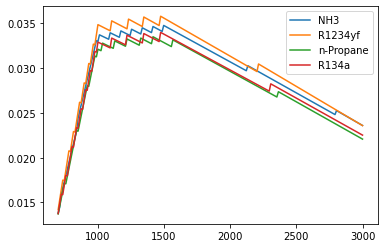

In [23]:
# Number of pressure values to sweep
n = 100
num_p1 = n
num_p2 = n

# Pressures to sweep
p1s = np.linspace(4e5, 1.1e6, num_p1)
p2s = np.linspace(4e5, 1.1e6, num_p2)

# Mesh of pressures
p1_mesh, p2_mesh = np.meshgrid(p1s, p2s)

# Select fluids
fluids = ["NH3", "R1234yf", "n-Propane", "R134a"]

df = pd.DataFrame(index = depths)

for fluid in fluids:
    state1, state2, state3, state4 = calc_state(p1_mesh.ravel(), p2_mesh.ravel(), sub = fluid)
    
    max_eff = []
    for depth in depths:
        temp = calc_temp(depth)
        invalids = calc_constraints(temp)
        efficiency = calc_efficiency(depth)
        efficiency[invalids] = None
        
        max_eff.append(np.nanmax(efficiency))
        
    df[fluid] = max_eff

df.plot()

## Fit a polynomial curve to approximate output

In [24]:
# fit a curve to smooth
def func_four(x, c, d, e, f, g):
    # Fourth order polynomial
    return c*x**4 + d*x**3 + e*x**2 + f*x + g
    
def func_six(x, a, b, c, d, e, f, g):
    # Sixth order polynomial
    return a*x**6 + b*x**5 + c*x**4 + d*x**3 + e*x**2 + f*x + g

def poly_fit(df, od = 6):
    # Make new dataframe to accomodate fit
    df_fit = pd.DataFrame(index = df.index)
    
    # Grab depths from original data
    xdata = df.index
    
    # Grab data for each column in original data
    for col in df.columns:
        ydata = df[col].tolist()
        
    # Run sixth order polynomial fit with scipy.optimize.curve_fit()
        if od == 6:
            popt, pcov = curve_fit(func_six, xdata, ydata)
            df_fit[col] = func_six(xdata, *popt)
    # Or fourth order fit
        elif od == 4:
            popt, pcov = curve_fit(func_four, xdata, ydata)
            df_fit[col] = func_four(xdata, *popt)
        
    return df_fit



## Plot

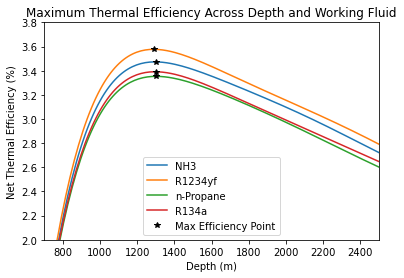

In [21]:
df_fit = poly_fit(df, od=6)
df_percent = df_fit*100
df_percent.plot()

for col in df_fit.columns:
    plt.plot(df_fit[col].idxmax(), df_fit[col].max()*100, 'k*')
plt.plot(0,0,'k*', label = 'Max Efficiency Point')
plt.legend()
plt.title("Maximum Thermal Efficiency Across Depth and Working Fluid")
plt.xlabel("Depth (m)")
plt.ylabel("Net Thermal Efficiency (%)")
plt.ylim(2, 3.8)
plt.xlim(700, 2500)
plt.show()